In [40]:
%pylab inline

# Import our plot library
from vplot import *

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns;
sns.set(style="white", color_codes=True)

SIMDIR="/storage/ileena/simulation/SSC/fig_haplo_paper/"
DATADIR="/storage/mgymrek/ssc-imputation/"
OUTPATH="pdfs/"
PREFIX="Figure4"

Populating the interactive namespace from numpy and matplotlib


In [80]:
# Functions for plotting

def PlotExample(ex_data, fname, color="black"):
    lw=1
    boxprops = dict(color=color, linewidth=lw)
    medianprops = dict(color=color, linewidth=lw)
    fig = plt.figure()
    fig.set_size_inches((6, 4))
    ax = fig.add_subplot(111)
    bp = ex_data.boxplot(column="pt", by="gt", ax=ax, grid=False, boxprops=boxprops, medianprops=medianprops,
                return_type='dict');

    [[item.set_linewidth(lw) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['means']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['caps']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['caps']] for key in bp.keys()]

    ax.set_title("")
    plt.suptitle("");
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("STR Genotype (bp relative to hg19)", size=20)
    ax.set_ylabel("Simulated phenotype", size=20);
    ax.set_xticklabels(ax.get_xticklabels(), size=15);
    ax.set_yticks(np.arange(-3, 3.1, 1))
    ax.set_yticklabels(ax.get_yticks(), size=15);
    fig.savefig(fname)
    
def PlotR2Pval(r2, assoc, fname):
    # Pull out SNPs
    str_coord = assoc[assoc["testclass"]=="STR"]["locus"].values[0]
    r2 = r2[r2["locus1"]==str_coord]
    r2["locus"] = r2["locus2"]
    snp_assoc = assoc[assoc["testclass"]=="SNP"]
    snp_assoc = pd.merge(snp_assoc, r2, on=["locus"])

    fig = plt.figure()
    fig.set_size_inches((6, 4))
    ax = fig.add_subplot(111)
    # Plotting all SNPs
    ax.scatter(snp_assoc["r2"], snp_assoc["pvalue"].apply(lambda x: -1*np.log10(x)), color="gray", s=8, label="SNPs");
    # Plot the STR
    ax.scatter([1.0], [assoc[assoc["testclass"]=="STR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[0]], color="red", s=40, label="STR")
    # Plot the imputed STR
    imp_ld = r2_imp[r2_imp["locus1"]==str_coord]["r2"].values[0]
    imp_p = assoc[assoc["testclass"]=="IMPSTR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[0]
    ax.scatter([imp_ld], [imp_p], color="blue", s=40, label="Imputed STR");
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("R2 with causal STR", size=15)
    ax.set_ylabel("-log10 P", size=15);
    ax.set_xticklabels(["%.1f"%x for x in ax.get_xticks()], size=12)
    ax.set_yticklabels(["%.1f"%x for x in ax.get_yticks()], size=12)
    ax.legend(loc="upper left");
    fig.savefig(fname)
    
def GetPower(x, alpha=0.05):
    return np.mean([(int(float(item) < alpha)) for item in x])

def PlotPower(assoc, fname, alpha=0.05, xlim=(0, 1), ylim=(0, 1)):
    # Calculate power for each class
    assoc_tmp = assoc.groupby(["str","testclass"], as_index=False).agg({"pvalue": lambda x: GetPower(x)})
    assoc_tmp["power"] = assoc_tmp["pvalue"]
    assoc_tmp = assoc_tmp[["str","testclass","power"]]
    impdata = assoc_tmp[assoc_tmp["testclass"]=="IMPSTR"].copy()
    snpdata = assoc_tmp[assoc_tmp["testclass"]=="SNP"].copy()
    strdata = assoc_tmp[assoc_tmp["testclass"]=="STR"].copy()
    impdata["imp_power"] = impdata["power"]
    snpdata["snp_power"] = snpdata["power"]
    strdata["str_power"] = strdata["power"]
    power = pd.merge(impdata[["str","imp_power"]], snpdata[["str", "snp_power"]], on=["str"])
    power = pd.merge(power, strdata[["str","str_power"]], on=["str"])
    power["powerdiff"] = power["imp_power"] - power["snp_power"]
    power["locus"] = power["str"]
    data = pd.merge(power, r2comp, on=["locus"])
    g = sns.jointplot(x="r2diff", y="powerdiff", data=data, xlim=xlim, ylim=ylim, stat_func=None, color="black", edgecolor="black", kind="kde")
    g.ax_joint.axvline(x=0, linestyle="dashed", color="gray")
    g.ax_joint.axhline(y=0, linestyle="dashed", color="gray")
    g.ax_joint.set_xlabel("r2imp-r2bestsnp", size=15)
    g.ax_joint.set_ylabel("powerimp-powerbestsnp", size=15)
    g.savefig(fname)
    print(data.shape[0])
    print(np.mean(data["r2diff"]))
    print(np.mean(data["powerdiff"]))
    print(np.mean(data["powerdiff"]>0))

In [2]:
# Load LD values
r2_snp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_snp.tab"), sep="\t")
r2_imp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_imp.tab"), sep="\t")
best_snp = r2_snp.groupby("locus1", as_index=False).agg({"r2": max, "freq_het": np.mean})
r2comp = pd.merge(best_snp, r2_imp, on=["locus1"])[["locus1","freq_het_x","r2_x","r2_y"]]
r2comp.columns = ["locus","het","r2_bestsnp","r2_ssc"]
r2comp["r2diff"] = r2comp["r2_ssc"]-r2comp["r2_bestsnp"]

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2106
0.17671083911799743
0.11041785375118708


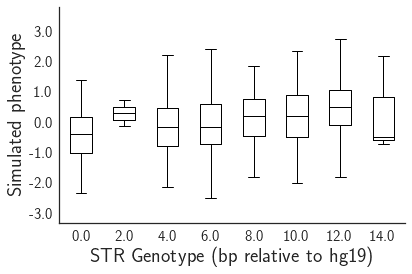

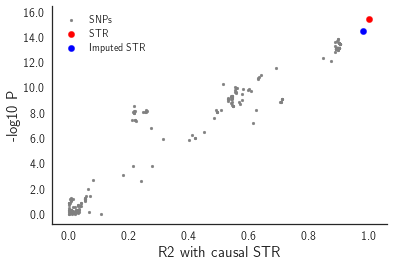

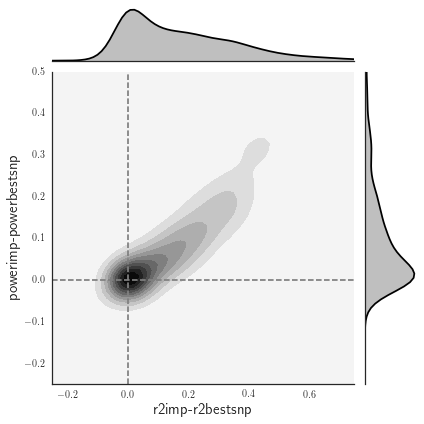

In [49]:
# Linear association
ex_gt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example.gt"), sep="\t")
ex_pt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])
ex_data = pd.merge(ex_gt_data, ex_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant.tab_power_simulation_results.txt"), sep="\t")
exassoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example_power_simulation_results.txt"), sep="\t")

PlotExample(ex_data, os.path.join(OUTPATH, "%s_ExampleAssociation.pdf"%PREFIX))
PlotR2Pval(r2_snp, exassoc, os.path.join(OUTPATH, "%s_r2vsP.pdf"%PREFIX))
PlotPower(assoc, os.path.join(OUTPATH, "%s_GWASPowerQuant.pdf"%PREFIX), xlim=(-0.25, 0.75), ylim=(-0.25, 0.5))

In [18]:
# Mean gain in r2 vs. num alleles
sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.results.csv"))
sscloo["locus"] = sscloo["pos"]
ldata = pd.merge(sscloo, r2comp, on=["locus"])
print(np.mean(ldata[(ldata["numAllele"]>=3)]["r2diff"]))
print(np.mean(ldata["r2diff"]))
print(np.mean(ldata["r2_ssc"]))
print(np.mean(ldata["r2_bestsnp"]))

0.19208581025369087
0.1765477122266534
0.9162909259509048
0.7397432137242514


5427
0.17792588043349442
0.049355076469504336


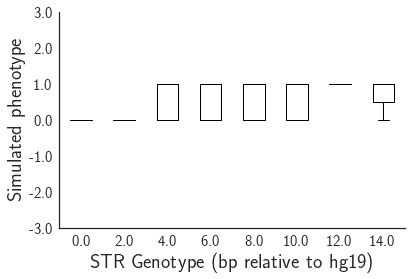

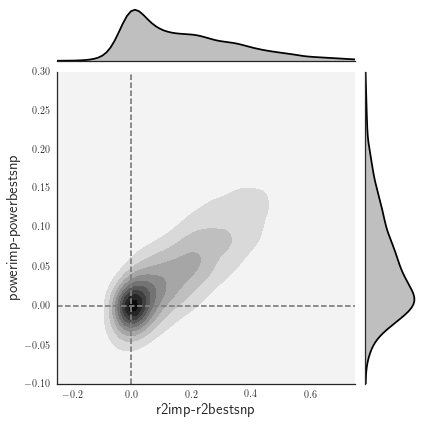

In [66]:
# Case control
ex_gt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example.gt"), sep="\t")
ex_pt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])
ex_data = pd.merge(ex_gt_data, ex_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_casecontrol.tab_power_simulation_results.txt"), sep="\t")
exassoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example_power_simulation_results.txt"), sep="\t")

PlotExample(ex_data, os.path.join(OUTPATH, "%s_CCExampleAssociation.pdf"%PREFIX))
PlotPower(assoc, os.path.join(OUTPATH, "%s_GWASPowerCC.pdf"%PREFIX), xlim=(-0.25, 0.75), ylim=(-0.1, 0.3))

5784
0.17644800861568083
0.17611671696215267
0.6051175656984785


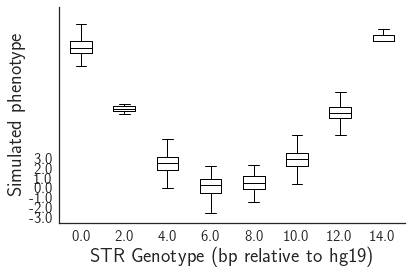

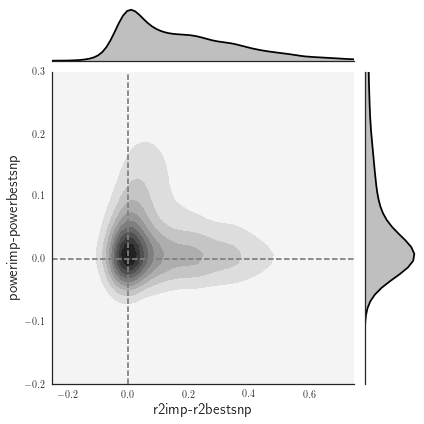

In [81]:
# Non-additive
SIMDIR="/storage/ileena/simulation/SSC/fig_haplo_paper/"

exp_gt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "suppl_chr21_23934706_pb_allelic.gt"), sep="\t")
exp_pt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "suppl_chr21_23934706_pb_allelic_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])
ex_data = pd.merge(exp_gt_data, exp_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]

assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "suppl_chr21_pb_allelic_b0.1_power_simulation_results.txt"), sep="\t")
assoc_filt = assoc.groupby(["simnum", "str", "testclass"],  as_index=False).pvalue.min()

PlotExample(ex_data, os.path.join(OUTPATH, "%s_NonADDExampleAssociation.pdf"%PREFIX))
PlotPower(assoc_filt, os.path.join(OUTPATH, "%s_GWASPowerNonADD_Allelic.pdf"%PREFIX), xlim=(-0.25, 0.75), ylim=(-0.2, 0.3))

5784
0.17644800861568083
0.023407676348547714


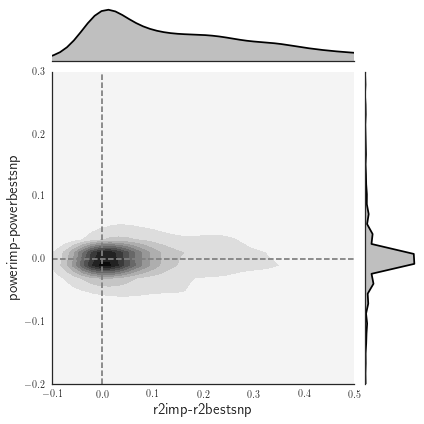

In [79]:
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "suppl_chr21_pb_b0.1_power_simulation_results.txt"), sep="\t")
PlotPower(assoc, os.path.join(OUTPATH, "%s_GWASPowerNonADD.pdf"%PREFIX), xlim=(-0.1, 0.5), ylim=(-0.2, 0.3))

# Supplementary Figure: r2imp-r2best vs. num alleles

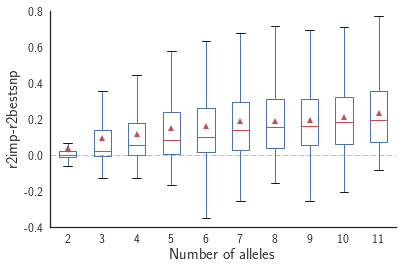

In [51]:
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ldata[ldata["numAllele"]<=10].boxplot(column="r2diff", by="numAllele", grid=False, ax=ax, showmeans=True);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.axhline(y=0, linestyle="dashed", color="gray", linewidth=0.5)
ax.set_ylim(bottom=-0.4, top=0.8)
ax.set_title("")
plt.suptitle("")
ax.set_xlabel("Number of alleles", size=15)
ax.set_ylabel("r2imp-r2bestsnp", size=15)
ax.set_xticklabels(ax.get_xticks()+1, size=12)
ax.set_yticklabels(["%.1f"%x for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "SuppFig_r2gain.pdf"))